# <div align="center"> Utilizing SVM and CNN Models for Breast Cancer Detection with Mammography and Ultrasound Imaging </div>

Group 5:
* Almira Zahra Aurelia – 00000080298
* Darren Irawan Djong – 00000081041
* Kayla Abigail Gunawan – 00000081824
* Sabrina Fajrul Ula Usman – 00000083124

# Breast Cancer Mammography with SVM

# Prepare and Collect Data

In [1]:
import os

data_path = "C:/Users/Hp/MACHINE LEARNING/Lab/ML PROJECT/NEWDATA/Dataset of Mammography with Benign Malignant Breast Masses/INbreast+MIAS+DDSM Dataset"
benign_path = os.path.join(data_path, "Benign Masses")
malignant_path = os.path.join(data_path, "Malignant Masses")

In [2]:
import cv2
from tqdm import tqdm

def load_images(folder_path, label):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))  # Resize the image as needed
        images.append(img)
        labels.append(label)
    return images, labels

In [3]:
benign_images, benign_labels = load_images(benign_path, "Benign Masses")
malignant_images, malignant_labels = load_images(malignant_path, "Malignant Masses")

100%|██████████| 13690/13690 [00:17<00:00, 762.38it/s]


In [4]:
all_images = benign_images + malignant_images
all_labels = benign_labels + malignant_labels

In [5]:
import numpy as np

X = np.array(all_images)
y = np.array(all_labels)

In [6]:
np.unique(y)

array(['Benign Masses', 'Malignant Masses'], dtype='<U16')

In [7]:
import pandas as pd

pd.Series(y).value_counts()

C:\Users\Hp\AppData\Local\Temp\ipykernel_1904\1149944248.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Malignant Masses    13690
Benign Masses       10846
Name: count, dtype: int64

In [8]:
X.shape

(24536, 100, 100, 3)

In [9]:
y.shape

(24536,)

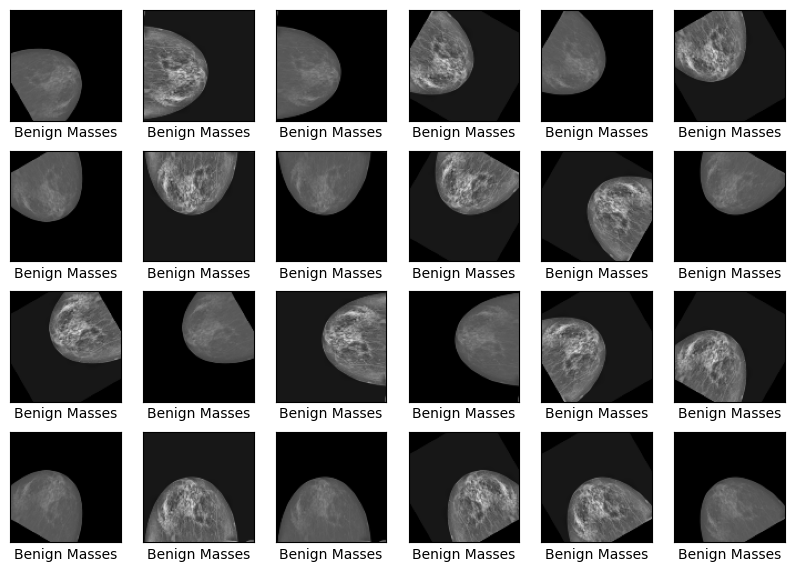

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 6, figsize=(10, 7))
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=y[i])

In [11]:
X = X.reshape(len(X), -1)
y = y.reshape(len(X), -1)

X.shape, y.shape

((24536, 30000), (24536, 1))

# Split Data

In [12]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=10, 
                                                test_size=.20)

In [13]:
Xtrain.shape, Xtest.shape

((19628, 30000), (4908, 30000))

# Feature Scalling

In [14]:
print(Xtrain.max(), Xtrain.min())
print(Xtest.max(), Xtest.min())

255 0
255 0


In [15]:
Xtrain = Xtrain/255
Xtest = Xtest/255
print(Xtrain.max(), Xtrain.min())
print(Xtest.max(), Xtest.min())

1.0 0.0
1.0 0.0


# Feature Selection

In [16]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='rbf', class_weight='balanced', probability=True)
model = make_pipeline(pca, svc)

# Train Model

In [17]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)

CPU times: total: 7h 19min 34s
Wall time: 5h 7min 38s


GridSearchCV(estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, whiten=True)),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             param_grid={'svc__C': [1, 5, 10, 50],
                         'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]})

In [18]:
print(grid.best_params_)

{'svc__C': 50, 'svc__gamma': 0.005}


In [19]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

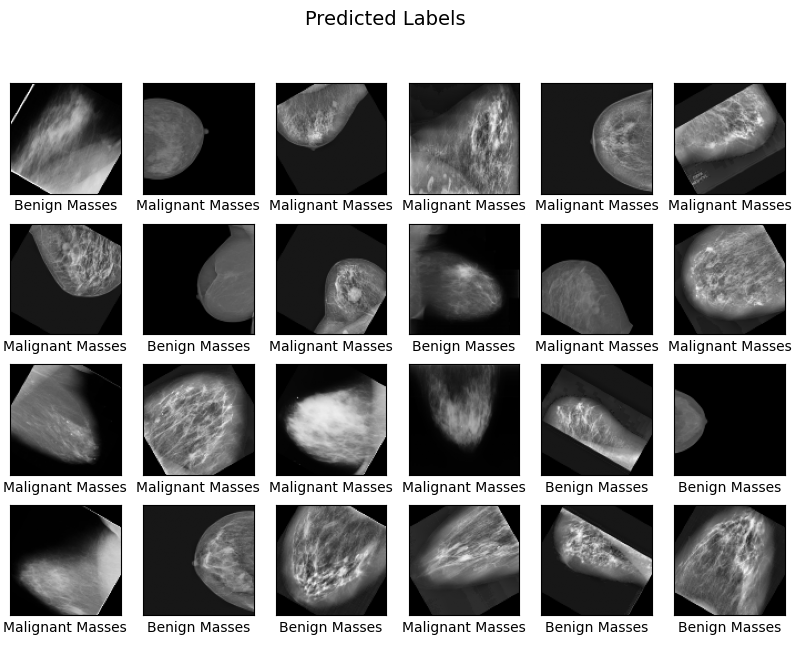

In [20]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 100, 100, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [21]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 19628
Jumlah sampel data pengujian: 4908


# Evaluation

In [22]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant'])

              precision    recall  f1-score   support

      benign       0.95      0.93      0.94      2164
   malignant       0.95      0.96      0.95      2744

    accuracy                           0.95      4908
   macro avg       0.95      0.95      0.95      4908
weighted avg       0.95      0.95      0.95      4908



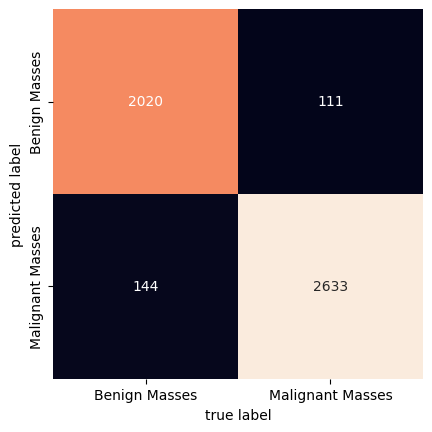

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [24]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.9997452618707968
Testing Score: 0.9480440097799511


# STRATIFIED K-FOLD CROSS VALIDATION

In [25]:
from sklearn.model_selection import StratifiedKFold

# Define the number of splits for stratified k-fold cross-validation
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize an empty list to store the cross-validation scores
stratified_k_fold_acc = []

# Iterate over the stratified k-fold splits
for train_index, val_index in skf.split(Xtrain, ytrain):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = Xtrain[train_index], Xtrain[val_index]
    y_train_fold, y_val_fold = ytrain[train_index], ytrain[val_index]

    # Fit the model on the training data for this fold
    model.fit(X_train_fold, y_train_fold)

    # Evaluate the model on the validation data for this fold
    fold_score = model.score(X_val_fold, y_val_fold)

    # Append the validation score to the list of cross-validation scores
    stratified_k_fold_acc.append(fold_score)

stratified_k_fold_acc

[0.9409067753438615,
 0.9424350483953133,
 0.9424350483953133,
 0.9454915944982171,
 0.9403973509933775,
 0.9358125318390219,
 0.9393785022924096,
 0.934793683138054,
 0.9322120285423038,
 0.9296636085626911]

In [26]:
# Calculate the mean accuracy of stratified k-fold cross-validation
stratified_k_fold_mean = np.mean(stratified_k_fold_acc)
stratified_k_fold_mean

0.9383526172000562

# NEW QUERY

In [27]:
import joblib

# Menyimpan model ke dalam file
joblib.dump(model, 'Mammography_SVM.model')

['Mammography_SVM.model']

In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Function to load and preprocess new query images from a specified folder
def load_and_preprocess_new_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping...")
                continue
            img = cv2.resize(img, (100, 100))  # Resize the image to match training data
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error occurred while processing image {img_path}: {e}")
    return images, labels

# Paths to new query images folders
new_query_benign_path = "C:/Users/Hp/MACHINE LEARNING/Lab/ML PROJECT/NEWDATA/DATA FOR NEW QUERY MAMMO/Benign Masses"  
new_query_malignant_path = "C:/Users/Hp/MACHINE LEARNING/Lab/ML PROJECT/NEWDATA/DATA FOR NEW QUERY MAMMO/Malignant Masses"  

# Load and preprocess new query images from both folders
new_query_benign_images, new_query_benign_labels = load_and_preprocess_new_images_from_folder(new_query_benign_path, 'Benign Masses')
new_query_malignant_images, new_query_malignant_labels = load_and_preprocess_new_images_from_folder(new_query_malignant_path, 'Malignant Masses')

# Combine images and labels from both folders
new_query_images = new_query_benign_images + new_query_malignant_images
new_query_labels = new_query_benign_labels + new_query_malignant_labels

# Convert the list of images to a numpy array and preprocess them
X_new_query = np.array(new_query_images)
X_new_query = X_new_query.reshape(len(X_new_query), -1)  # Flatten images
X_new_query = X_new_query / 255  # Scale the pixel values

# Load the saved model
model = joblib.load('Mammography_SVM.model')

# Predict using the trained model
y_new_query_pred = model.predict(X_new_query)

# Reshape the data back to the original shape for visualization
X_new_query_reshaped = X_new_query.reshape((X_new_query.shape[0], 100, 100, 3))

In [29]:
# Calculate and print accuracy
y_true = np.array(new_query_labels)
y_pred = y_new_query_pred

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy on new query images: {accuracy:.2f}')

# Print classification report
print(classification_report(y_true, y_pred, target_names=['Benign Masses', 'Malignant Masses']))

Accuracy on new query images: 0.97
                  precision    recall  f1-score   support

   Benign Masses       0.95      1.00      0.98        20
Malignant Masses       1.00      0.95      0.97        20

        accuracy                           0.97        40
       macro avg       0.98      0.97      0.97        40
    weighted avg       0.98      0.97      0.97        40



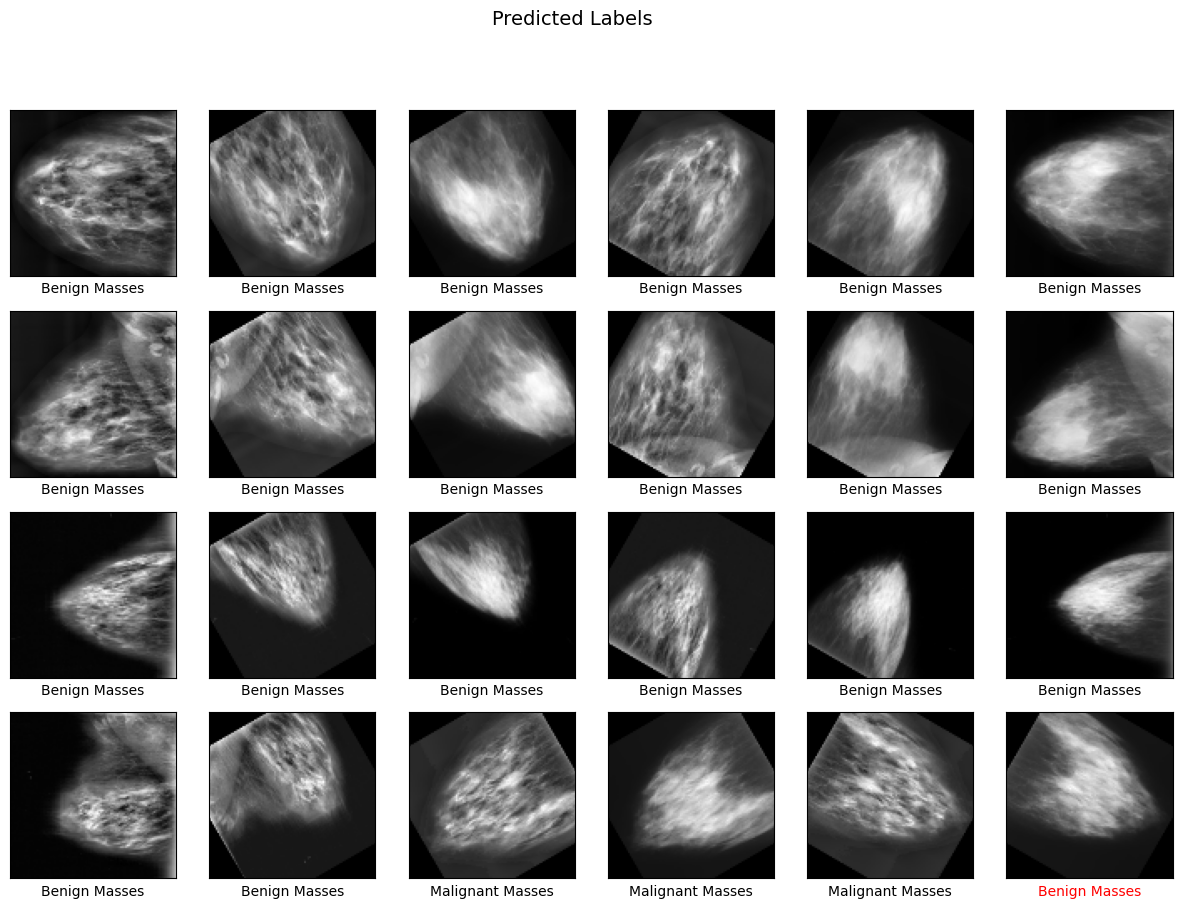

In [30]:
# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(15, 10))

for i, axi in enumerate(ax.flat):
    if i < len(new_query_images):
        axi.imshow(cv2.cvtColor(new_query_images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        color = 'black' if y_new_query_pred[i] == y_true[i] else 'red'
        axi.set(xticks=[], yticks=[])
        axi.set_xlabel(f'{y_new_query_pred[i]}', color=color)
    else:
        axi.axis('off')

fig.suptitle('Predicted Labels', size=14)
plt.show()

---